# Correlated Truncation Errors in Effective Field Theory: The code behind the manuscript

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.

In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import urllib
import tables

%matplotlib inline

In [2]:
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

In [3]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

edgewidth = 0.6

## Section II: The Model

### Figure 1: Predictions to Coefficients

First we set up our toy data. Each coefficient in the EFT is a sample from a GP, with a squared exponential kernel, and the same correlation length (0.2) and standard deviation (1) at each order. The expansion parameter is 0.5 (quite large). The code below first generates the coefficients, and then creates predictions that are a sum of these order-by-order pieces by following
$$\begin{align}
y_k = y_{ref} \sum_{n=0}^k c_n Q^n
\end{align}$$
Note that within the toy model, one is guaranteed to recover the individual realizations of the GP $c_n$ by inverting this relation *if one has chosen the correct expansion parameter*.

In [4]:
x = np.linspace(0, 1, 100)
X = x[:, None]  # make a 2D version of x to match the input data structure from SciKitLearn
n_orders = 4    # Here we examine the case where we have info on four non-trivial orders
orders = np.arange(0, n_orders)

final_order = 20  # We are going to treat the order-20 result as the final, converged answer
orders_all = np.arange(0, final_order+1)

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd = 1
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = 3


# X_mask = np.array([i % 5 == 0 for i in range(len(X_all))])[:, None]

kernel = RBF(length_scale=ls, length_scale_bounds='fixed') + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
gp = gm.ConjugateGaussianProcess(kernel=kernel, center=center, df=np.inf, scale=sd, nugget=0)

# Draw coefficients and then use `partials` to create the sequence of partial sums
# that defines the order-by-order EFT predictions
# Negative sign to make y_n positive, for aesthetics only
coeffs_all = - gp.sample_y(X, n_samples=final_order+1, random_state=seed)
data_all = gm.partials(coeffs_all, ratio, ref=ref, orders=orders_all)
diffs_all = np.array([data_all[:, 0], *np.diff(data_all, axis=1).T]).T

# Get the "all-orders" curve
data_true = data_all[:, -1]

# Will only consider "known" lower orders for most of the notebook
coeffs = coeffs_all[:, :n_orders]
data = data_all[:, :n_orders]
diffs = diffs_all[:, :n_orders]

Now we can make Fig. 1(a) from the paper

In [5]:
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor=softblack,
    mode='expand',
    fancybox=False
)

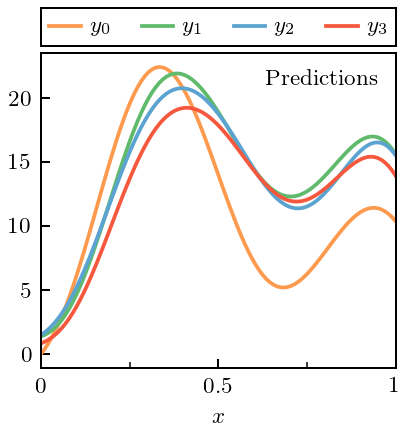

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i, curve in enumerate(data.T):
    ax.plot(x, curve, label=r'$y_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Predictions', ha='right', va='top',
        transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')
ax.set_xticks([0, 0.5, 1])
ax.set_xticks([0.25, 0.75], minor=True)
ax.set_xticklabels([0, 0.5, 1])
ax.set_xlim(0, 1)
fig.tight_layout()

fig.savefig('figures/Predictions_Only_{}'.format(n_orders-1))

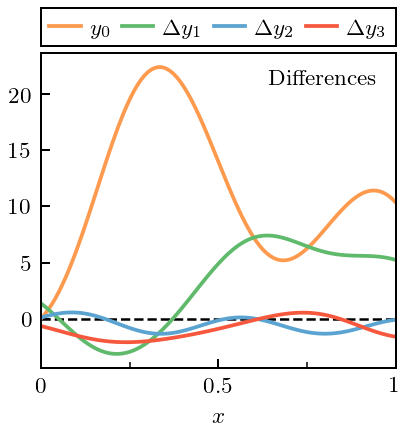

In [7]:
# Puts y at baseline, see
# https://matplotlib.org/2.2.2/gallery/text_labels_and_annotations/usetex_baseline_test.html
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

    ax.axhline(0, lw=1, ls='--', c=softblack)
    # For the zeroth-order, only, use the data itself
    ax.plot(x, data[:, 0], label=r'$y_0$', c=colors[0])
    for i in range(1, n_orders):
        # Beyond that, use differences
        ax.plot(x, diffs[:, i], label=r'$\Delta y_{}$'.format(i), c=colors[i])

    ax.text(0.95, 0.95, 'Differences', ha='right', va='top',
               transform=ax.transAxes)

    legend = ax.legend(**top_legend_kwargs)

    # Format
    ax.set_xlabel(r'$x$')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticks([0.25, 0.75], minor=True)
    ax.set_xticklabels([0, 0.5, 1])
    ax.set_xlim(0, 1)
    fig.tight_layout()
    plt.show()  # Render before leaving rc_context

    fig.savefig('figures/Differences_Only_{}'.format(n_orders-1))

Now show the coefficients $c_n$ (each drawn from one underlying Gaussian Process).
Of course, in a real application, these coefficients would be extracted from the EFT predictions by diving $\Delta y_n$ by $Q^n$.

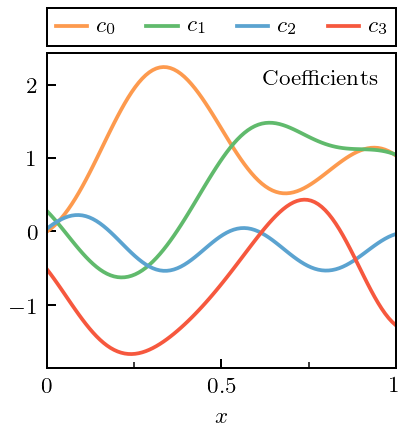

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i in range(n_orders):
    ax.plot(x, coeffs[:, i], label=r'$c_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Coefficients', ha='right', va='top',
           transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')
ax.set_xticks([0, 0.5, 1])
ax.set_xticks([0.25, 0.75], minor=True)
ax.set_xticklabels([0, 0.5, 1])
ax.set_xlim(0, 1)
fig.tight_layout()

fig.savefig('figures/Coefficients_Only_{}'.format(n_orders-1))

### Figure 3: Curvewise vs Pointwise Analysis

This next piece of code returns to the curves from Fig. 1(c), and then chooses specific points $x_i$ and computes the standard deviation of the $c_n(x_i)$. It compares that to the standard deviation of the underlying GP.
This "pointwise" approach was employed in Melendez et al. (2017) using a Bayesian formalism. The new GP approach has the advantage of combining data from across the domain (accounting for correlations!) to estimate the variance $\bar c$.

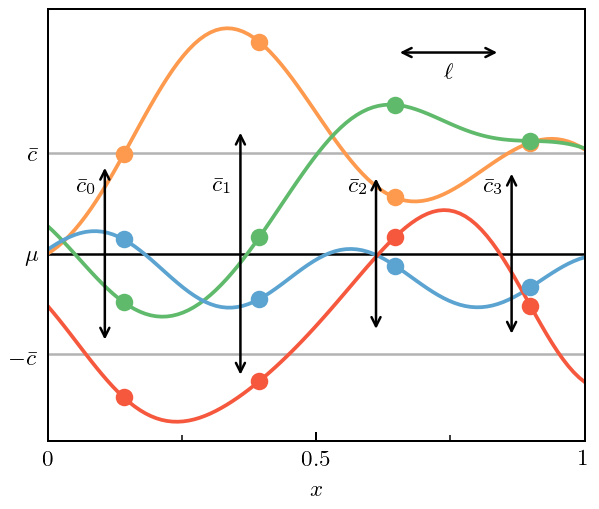

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

# Select and indicate the points at which the pointwise cbars will be estimated
mask = np.array([(i-14) % 25 == 0 for i in range(len(x))])
for i, c in enumerate(coeffs.T):
    ax.plot(x, c, color=colors[i], zorder=0)
    ax.plot(x[mask], c[mask], ls='', marker='o', color=colors[i])

# Indicate the pointwise errors  
for i, xi in enumerate(x[mask]):
    # Fit a Gaussian to the orders at this x_i
    sd_fit = stats.norm.fit(coeffs[mask][i], floc=0, shape=len(coeffs[mask]))[1]
    # Draw a vertical arrow showing mean +/- sd
    ax.annotate(
        "", xy=(xi-0.035, sd_fit), xytext=(xi-0.035, -sd_fit), zorder=1,
        arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1, color=softblack),
    )
    ax.text(xi-0.07, 0.65, r'$\bar c_{}$'.format(i), horizontalalignment='center',
            verticalalignment='center', zorder=1)    

# Draw length scale
ax.annotate("", xy=(x[mask][2], 2*sd), xytext=(x[mask][2]+ls, 2*sd),
            arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                            color=softblack), zorder=1)
ax.text(x[mask][2]+ls/2, 1.79*sd, r'$\ell$', horizontalalignment='center',
            verticalalignment='center', zorder=1)

# Format plot
ax.axhline(0, 0, 1, c=softblack, lw=1, zorder=-1)
ax.axhline(1, 0, 1, c=gray, lw=1, zorder=-1)
ax.axhline(-1, 0, 1, c=gray, lw=1, zorder=-1)
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels([r'$-\bar c$', r'$\mu$', r'$\bar c$'])
ax.tick_params(length=0, axis='y')
ax.set_xlabel(r'$x$')
ax.set_xticks([0, 0.5, 1])
ax.set_xticks([0.25, 0.75], minor=True)
ax.set_xticklabels([0, 0.5, 1])

fig.tight_layout();

fig.savefig('figures/annotated_gp_pointwise_combined')

### Figure 4: Interpolation and Regression with Gaussian Processes

Now we do an example of interpolation, where the training points are exact ($\sigma_n=0$) and regression, where the training points have some errors (we choose $\sigma_n=0.15$).
Training points are shown, with true curves indicated as solid lines, and mean of GP the dashed line. The bands are 95% (2$\sigma$) credible intervals.
For this exercise we choose the underlying curves to be $c_1$ (interpolation) and $c_3$ (regression). 

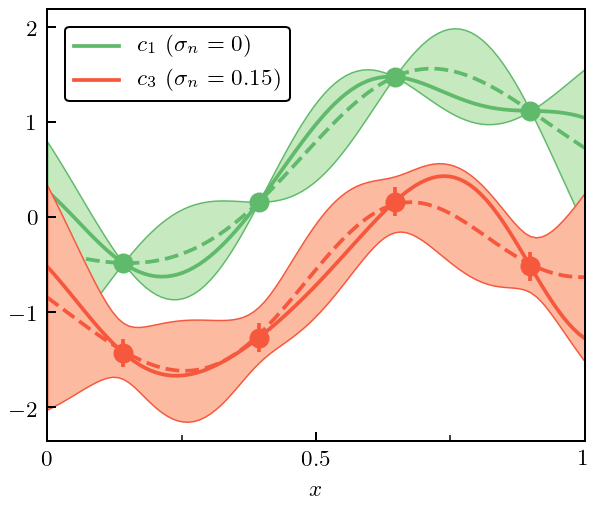

In [10]:
regres_sd = 0.15

# Set up gp objects with fixed mean and standard deviation
gp_interp = gm.ConjugateGaussianProcess(
    kernel=kernel, center=center, disp=0, df=np.inf, scale=sd, nugget=0)
gp_regres = gm.ConjugateGaussianProcess(
    kernel=kernel, center=center, disp=0, df=np.inf,
    scale=sd, nugget=regres_sd**2)

# Condition on data and make predictions
interp_idx = 1  # pick out c_1
gp_interp.fit(X[mask], coeffs[mask, [interp_idx]])
pred_interp, std_interp = gp_interp.predict(X, return_std=True)

regres_idx = 3  # pick out c_3
gp_regres.fit(X[mask], coeffs[mask, [regres_idx]])
pred_regres, std_regres = gp_regres.predict(X, return_std=True)


fig, ax = plt.subplots(figsize=(3.5, 3))

# Interpolating curve
ax.plot(x, coeffs[:, [interp_idx]], c=colors[interp_idx],
        label=r'$c_{}$ ($\sigma_n = 0$)'.format(interp_idx), zorder=0)
ax.plot(x, pred_interp, c=colors[interp_idx], ls='--', zorder=0)
ax.plot(x[mask], coeffs[mask, interp_idx], ls='', marker='o', c=colors[interp_idx],
        markersize=7, zorder=0)
ax.fill_between(x, pred_interp - 2*std_interp, pred_interp + 2*std_interp, facecolor=light_colors[interp_idx],
                edgecolor=colors[interp_idx], lw=edgewidth, zorder=0)

# With noise
ax.plot(x, coeffs[:, [regres_idx]], c=colors[regres_idx],
        label=r'$c_{}$ ($\sigma_n = 0.15$)'.format(regres_idx), zorder=1)
ax.plot(x, pred_regres, c=colors[regres_idx], ls='--', zorder=1)
ax.errorbar(x[mask], coeffs[mask, regres_idx], regres_sd, c=colors[regres_idx],
            ls='', marker='o', markersize=7, zorder=2)
ax.fill_between(x, pred_regres - 2*std_regres, pred_regres + 2*std_regres, facecolor=light_colors[regres_idx],
                edgecolor=colors[regres_idx], lw=edgewidth, zorder=1)

# Format plot
ax.set_xticks([0, 0.5, 1])
ax.set_xticks([0.25, 0.75], minor=True)
ax.set_xticklabels([0, 0.5, 1])
ax.set_xlabel(r'$x$')
ax.legend()

fig.tight_layout();
fig.savefig('figures/coeff_interp_and_noise_example')

### Figure 5: GP Priors

Now we plot the priors on our GP. The prior on $\mu$ is a Gaussian, for a given value of $\bar{c}$. For $\bar{c}$ we take a prior that is an inverse $\chi^2$ distribution. The parameters of the $\chi^2$ are:
1. $\nu_0$, the prior number of degrees of freedom;
2. $\tau_0^2$, the prior scale. If $\nu$ becomes large this becomes the MAP value for $\bar{c}$. 

Note that in the opposite limit, where $\nu_0=0$ the prior becomes the scale invariant "Jeffreys prior".

The joint prior pdf is then
$$\mu,\bar{c}^2 \sim N \chi^{-2}(\eta_0,V_0,\nu_0,\tau_0^2)$$

This is mathematically equivalent to a normal-inverse-gamma prior, a fact which we exploit below.

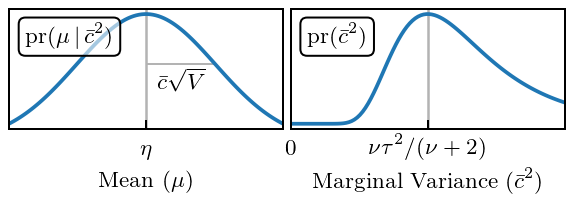

In [11]:
mean = 0
# The uncertainty (std-dev) of mu is Sqrt(V) times cbar,
# the plot is generated for V=1
disp = 1
df = 15
tau2 = (df + 2) / df  # Will put the mode at $\bar c = 1$
gaussian_sd = np.sqrt(tau2*disp)

# Convert to inverse gamma
a = df / 2.
b = df * tau2 / 2.

gaus = stats.norm(mean, gaussian_sd)
igam = stats.invgamma(a, scale=b)
mu_vals = np.linspace(-2.1, 2.1, 100)
cbar_vals = np.linspace(0, 2, 100)

fig, ax = plt.subplots(1, 2, figsize=(3.4, 1.3))

# Plot curves
ax[0].plot(mu_vals, gaus.pdf(mu_vals))
ax[1].plot(cbar_vals, igam.pdf(cbar_vals))

# Add text boxes
ax[0].text(0.06, 0.87, r'pr($\mu \,|\, \bar c^2$)', ha='left', va='top',
           transform=ax[0].transAxes,
           bbox=text_bbox)
ax[1].text(0.06, 0.87, r'pr($\bar c^2$)', ha='left', va='top',
           transform=ax[1].transAxes,
           bbox=text_bbox
          )

# Format plots
line_color = gray
ax[0].set_xlabel(r'Mean ($\mu$)', labelpad=4.5)
# ax[0].set_xlabel(r'Mean ($\mu$)')
ax[1].set_xlabel(r'Marginal Variance ($\bar c^2$)')
ax[0].set_yticks([])
ax[1].set_yticks([])
# plt.xlabel()

ax[0].axvline([mean], 0, 1, c=line_color, zorder=0, lw=1)
# ax[0].set_xticks([-gaussian_sd, mean, gaussian_sd])
# ax[0].set_xticklabels([r'$-\bar c\sqrt{V}$', r'$\eta$', r'$\bar c\sqrt{V}$'], va='bottom')
ax[0].set_xticks([mean])
ax[0].set_xticklabels([r'$\eta$'], va='bottom')
ax[0].tick_params(pad=12)
ax[0].arrow(0, gaus.pdf(gaussian_sd), gaussian_sd, 0, color=line_color, head_width=0., width=0.0001)
# ax[0].text(gaussian_sd+0.25, gaus.pdf(gaussian_sd), r'$\bar c\sqrt{V}$',
#            verticalalignment='center', horizontalalignment='left')
ax[0].text(gaussian_sd/2, gaus.pdf(gaussian_sd)-.02, r'$\bar c\sqrt{V}$',
           verticalalignment='top', horizontalalignment='center')
ax[1].axvline([df * tau2 / (df+2)], 0, 1, c=line_color, zorder=0, lw=1)
ax[1].set_xticks([0, df * tau2 / (df+2)])
ax[1].set_xticklabels([0, r'$\nu\tau^2/(\nu+2)$'], va='bottom')
ax[1].tick_params(pad=12)

fig.tight_layout(w_pad=0)
fig.savefig('figures/priors')

### Figure 6: Applications

We now consider three different situations where we can use our formalism to compute truncation errors.
1. Straightforward computation in the situation that computing $y_k(x)$ is "cheap", and we can evaluate it at as many points as we wish.
2. The situation where computing $y_k(x)$ is expensive, and we wish to obtain the uncertainty at some $x$, where $y_k(x)$ was not explicitly computed. In this situation we will use our GPs for interpolation too, and then combine the interpolation and truncation error to assess the overall error of our prediction.
3. Truncation errors in the presence of constraints, i.e., a situation where a symmetry guarantees that $\delta y_k(x_0)=0$ at some particular $x_0$.

#### Figure 6(a): Inexpensive Systems

In the figure we show the "EFT prediction" $y_n(x)$ at each order $n$, together with the associated 95% credible interval. The code to do this is actually just two lines, now that we have set up the input data, the mask, and the GP kernel. 

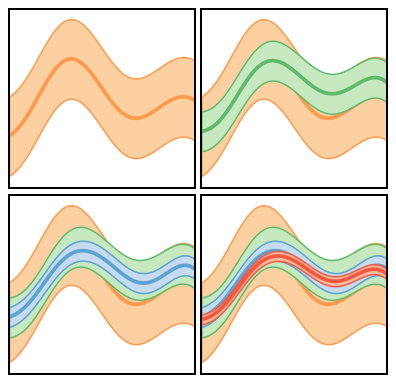

In [12]:
# By setting disp=0 and df=inf, no updating of hyperparameters occurs
# The priors become Dirac delta functions at mu=center and cbar=scale
# But this assumption could be relaxed, if desired
trunc_gp = gm.TruncationGP(kernel=kernel, ref=ref, ratio=ratio, disp=0, df=np.inf, scale=1, optimizer=None)
# Still only fit on a subset of all data to update mu and cbar!
# We must beware of numerical issues of using data that are "too close"
trunc_gp.fit(X[mask], data[mask], orders=orders)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2.37, 2.3))
for i, n in enumerate(orders):
    # Only get the uncertainty due to truncation (kind='trunc')
    _, std_trunc = trunc_gp.predict(X, order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x, data[:, i], zorder=i-5, c=colors[i])
        ax.fill_between(x, data[:, i] + 2*std_trunc, data[:, i] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(-15, 37)
fig.tight_layout(h_pad=0.3, w_pad=0.3);

fig.savefig('figures/gps_plus_trunc_errors')

#### Figure 6(b): Expensive Systems

The figures in this case are similar, but now the GP is trained only at the points indicated by the dots.
The total error bands now include both truncation and interpolation error.
Note how the total error on the EFT prediction expands or contracts as one moves away from or towards the points where we have "exact" EFT calculations.

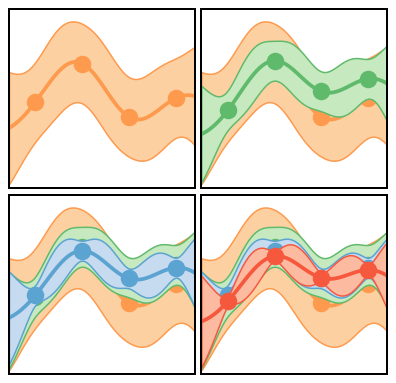

In [13]:
trunc_gp_exp = gm.TruncationGP(kernel=kernel, ref=ref, ratio=ratio, disp=0, df=np.inf, scale=1, optimizer=None)
trunc_gp_exp.fit(X[mask], data[mask], orders=orders)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2.37, 2.3))
for i, n in enumerate(orders):
    pred_exp, std_trunc_exp = trunc_gp_exp.predict(X, order=n, return_std=True)
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x, pred_exp, zorder=i-5, c=colors[i])
        ax.plot(x[mask], data[mask, i], ls='', c=colors[i], marker='o', zorder=i-5)
        ax.fill_between(x, pred_exp + 2*std_trunc_exp, pred_exp- 2*std_trunc_exp,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    # ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xticks([])
    # ax.set_yticks([-10, 0, 10, 20, 30])
    ax.set_yticks([])
    ax.set_ylim(-15, 37)
# Format
# axes[1, 0].set_xlabel(r'$x$')
# axes[1, 1].set_xlabel(r'$x$')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
fig.savefig('figures/gps_interp_and_trunc_errors')

#### Figure 6(c): Constraints

We now consider the case that the observable in question is constrained to be zero at both x=0 and x=1. This means that the EFT should maintain that constraint at all orders, and that the truncation-error model should incorporate that constraint. The truncation classes in `gsum` have two parameters in their `.fit` methods that permit the inclusion of constraints: `dX` and `dy`. Using that feature, things proceed in parallel to Fig. 6(a).

In [14]:
# This generates data that are constrained as described above
x2 = np.linspace(0, 1, 50)
X2 = x2[:, None]
kernel2 = RBF(length_scale=0.25) + WhiteKernel(noise_level=1e-7)

gp_constrained = gm.ConjugateGaussianProcess(kernel=kernel2, optimizer=None).fit([[0], [1]], [0, 0])
cn_constrained = gp_constrained.sample_y(X2, n_samples=n_orders, random_state=5)
yn_constrained = gm.partials(cn_constrained, ratio=ratio)

Here we give the code used to create the vertical legend in Fig. 6.
This can be ignored.

In [15]:
def vertical_legend(line_list, fill_list, patch_length=12, pad=4, sep=3.2, ax=None):
    """A very messy way to create a vertical legend! Will clean up later"""
    from matplotlib.offsetbox import TextArea, DrawingArea, VPacker
    from matplotlib.collections import BrokenBarHCollection
    import matplotlib.patches as mpatches
    from matplotlib.offsetbox import AnchoredOffsetbox
    
    if ax is None:
        ax = plt.gca()

    color_dict = {
        "LOp": plt.get_cmap("Greys"),
        "LO": plt.get_cmap("Purples"),
        "NLO": plt.get_cmap("Oranges"),
        "N2LO": plt.get_cmap("Greens"),
        "N3LO": plt.get_cmap("Blues"),
        "N4LO": plt.get_cmap("Reds")
    }
    ords = ['NLO', 'N2LO', 'N3LO', 'N4LO']

    p_decimal_list = [0.68, 0.95]
    edge_list = ["none", "none"]
    width_list = [0.5, 0.0]
    hatch_list = ["", ""]

    fill_transparency = 1

    kw_list = []
    for line_color, fill_colors in zip(line_list, fill_list):
        kw_list.append(
            {
                "edgecolor": line_color,
                "facecolor": fill_colors[1],
                "linewidth": 1
            }
        )
    word_boxes = []
    orders_list = [r"$y_0$", r"$y_1$", r"$y_2$", r"$y_3$"]
    for word in orders_list:
        ta = TextArea(
                     word,
                     textprops=dict(color="k",
                                    rotation=-90,
                                    va="bottom",
                                    ha="right",
                                    rotation_mode="anchor",
                                    size=8
                                    ),
                     )
        word_boxes.append(
            ta
        )

    patches_list = []
    patch_width = 7
    patch_height = 13
    patch_x = 2 - patch_width/2
    patch_y = 0
    bar_start = -1
    bar_light_width = 2.2
    bar_dark_width = 1.3
    bar_line_width = 0
    
    for i, order in enumerate(ords):
        hndls = BrokenBarHCollection(
            xranges=(
                     (bar_start, 2*bar_light_width+2*bar_dark_width+bar_line_width),
                     (bar_start+bar_light_width, 2*bar_dark_width),
                     ),
            yrange=(0, patch_length),
            facecolors=(fill_list[i],
                        line_list[i],
                        line_list[i],
                        fill_list[i]
                        ),
            edgecolor=line_list[i],
            # edgewidth=.6,
            linewidths=(0.4, 0),
            antialiaseds=True
            )
        patches_list.append(
            hndls
        )
    patch_boxes = []
    for patch in patches_list:
        patchbox = DrawingArea(4, patch_length, 0, 0)
        patchbox.add_artist(patch)
        patch_boxes.append(patchbox)

    all_boxes = []
    for i in range(len(patch_boxes)):
        subbox = VPacker(children=[patch_boxes[i], word_boxes[i]], align="center",
                  pad=1, sep=5)
        all_boxes.append(subbox)

    box = VPacker(children=all_boxes,
                  align="bottom",
                  pad=pad, sep=sep)
    # return box
    anchored_box = AnchoredOffsetbox(
         loc=2,
         child=box, pad=0.,
         frameon=True,
         bbox_to_anchor=(1.03, 1),
         bbox_transform=ax.transAxes,
         borderpad=0.
         )
    # anchored_box.patch.set_linewidth(0.8)
    ax.add_artist(anchored_box)
    return ax

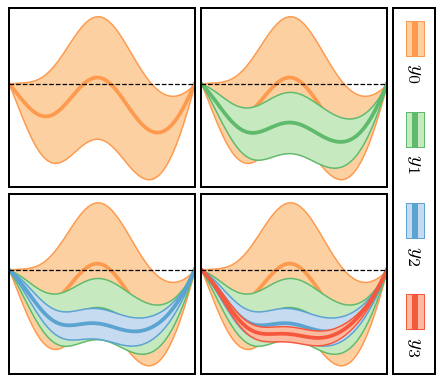

In [16]:
trunc_gp_sym = gm.TruncationGP(kernel=kernel2, ref=1, ratio=ratio, disp=0, df=np.inf, scale=1, optimizer=None)
trunc_gp_sym.fit(X2[::10], yn_constrained[::10], orders=orders, dX=np.array([[0], [1]]), dy=np.array([0, 0]))

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2.37, 2.3)
                        )
for i, n in enumerate(orders):
    # Again, only consider the truncation errors for this plot
    _, std_sym = trunc_gp_sym.predict(X2, order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x2, yn_constrained[:, i], zorder=i-5, c=colors[i])
        ax.fill_between(x2, yn_constrained[:, i] + 2*std_sym, yn_constrained[:, i] - 2*std_sym,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.axhline(0, 0, 1, ls='--', lw=0.5, c=softblack, zorder=0)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout(h_pad=0.3, w_pad=0.3);
vertical_legend(colors, light_colors, patch_length=14, sep=7.6, ax=axes[0, 1])
fig.savefig('figures/gps_with_sym_constraints_and_errors')

## Section III: Diagnostics

### Figure 7

In [17]:
MD_label = r'$\mathrm{D}_{\mathrm{MD}}^2$'
PC_label = r'$\mathrm{D}_{\mathrm{PC}}$'

#### Figure 7(a)


Here we split the data into a "training set" and a "testing set". The training set is indicated by the dots, and gives the data to which the GP used to assess the truncation error is fit. The location of the testing point is indicated by the tick marks on the x-axis. The solid line indicates the mean value of the GP for each EFT coefficient and the bubbles at the 95% DoB interval.

In [18]:
def regular_train_test_split(x, dx_train, dx_test, offset_train=0, offset_test=0, xmin=None, xmax=None):
    train_mask = np.array([(i - offset_train) % dx_train == 0 for i in range(len(x))])
    test_mask = np.array([(i - offset_test) % dx_test == 0 for i in range(len(x))])
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    train_mask = train_mask & (x >= xmin) & (x <= xmax)
    test_mask = test_mask  & (x >= xmin) & (x <= xmax) & (~ train_mask)
    return train_mask, test_mask

In [19]:
x_train_mask, x_valid_mask = regular_train_test_split(
    x, dx_train=24, dx_test=6, offset_train=1, offset_test=1)

# Hyperparameters
center0 = 0
disp0 = 0
df0 = 1
scale0 = 1

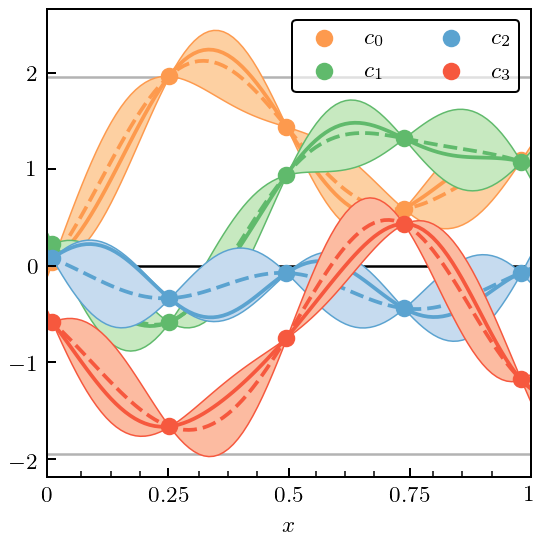

In [20]:
kernel_fit = RBF(length_scale=ls) + WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')

gp_diagnostic = gm.ConjugateGaussianProcess(kernel=kernel_fit, center=center0, disp=disp0, df=df0, scale=scale0)
gp_diagnostic.fit(X[x_train_mask], coeffs[x_train_mask])
pred, std = gp_diagnostic.predict(X, return_std=True)
underlying_std = np.sqrt(gp_diagnostic.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(orders):
    ax.plot(x, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(x, coeffs[:, i], c=colors[i], zorder=i-5)
    ax.plot(x[x_train_mask], coeffs[x_train_mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
            label=r'$c_{}$'.format(n))
    ax.fill_between(x, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(x[x_valid_mask], minor=True)
ax.set_xlabel(r'$x$')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax.tick_params(which='minor', bottom=True, top=False)
ax.legend(ncol=2, borderaxespad=0.5, borderpad=0.4)
fig.tight_layout();
fig.savefig('figures/toy_interp_and_underlying_processes')

Here are the best guesses for $\bar c$ and $\ell$ after performing the fit

In [21]:
print(r'Std. dev. expected value:', underlying_std)

Std. dev. expected value: 0.9775294031162108


In [22]:
np.sqrt(gp_diagnostic.df_ * gp_diagnostic.scale_**2 / (gp_diagnostic.df_ + 2))

0.888469885109714

In [23]:
# Print out the kernel of the fitted GP
gp_diagnostic.kernel_

RBF(length_scale=0.199) + WhiteKernel(noise_level=1e-10)

#### Figure 7(b): Squared Mahalanobis distance

This is like a $\chi^2$ in the presence of correlations.
The correlations are assessed using the covariance matrix of the fitted GP.

In [24]:
mean_underlying = gp_diagnostic.mean(X[x_valid_mask])
cov_underlying = gp_diagnostic.cov(X[x_valid_mask])
gdgn = gm.GraphicalDiagnostic(coeffs[x_valid_mask], mean_underlying, cov_underlying, colors=colors,
                              gray=gray, black=softblack)

In [25]:
def offset_xlabel(ax):
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

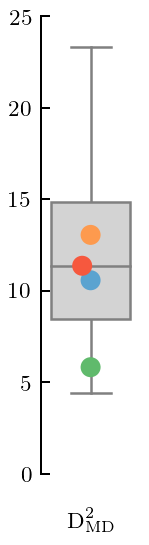

In [26]:
fig, ax = plt.subplots(figsize=(1, 3.2))
ax = gdgn.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 25)
fig.tight_layout();
fig.savefig('figures/toy_md_true_Q')

#### Figure 7(c): Pivoted Cholesky errors
Now we decompose the Mahalanobis distance into its component pieces, by doing a Pivoted Cholesky decomposition on the covariance matrix. The resulting PC errors are then plotted against index. The index can be related to the testing point in question, see Bastos & O'Hagan's seminal article. Note that gsum has the ability to display Pivoted Cholesky (and several other) decompositions of the MD, see third line of code below. 

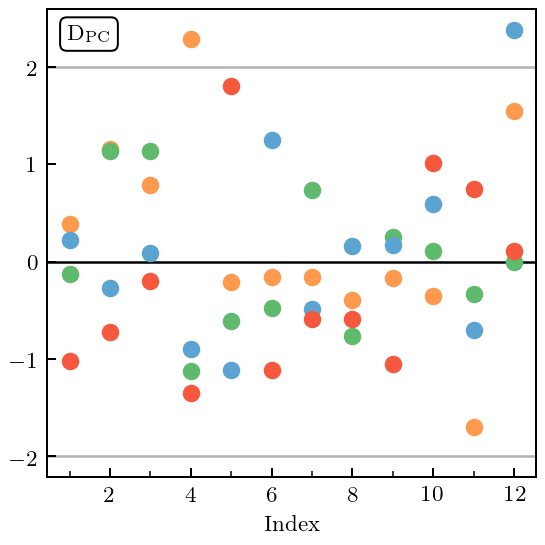

In [27]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gdgn.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xticks([1, 3, 5, 7, 9, 11], minor=True)
    ax.text(0.04, 0.967, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig('figures/toy_pc_vs_index_true_Q')

### Figure 8

Now we compare the truncation errors computed at each order using the GP obtained above with the "true" (summed to order $n=20$) result from the toy EFT (dashed line), see Fig. 8(a). This comparison is done at the validation points indicated by the tick marks on the x-axis and produces the "Credible Interval Diagnostic" plot of Fig. 8(b). Note that `gsum` also has a command to generate this plot.

In [28]:
gp_trunc = gm.TruncationGP(kernel=kernel_fit, ref=ref, ratio=ratio, center=center0, disp=disp0, df=df0, scale=scale0)
gp_trunc.fit(X[x_train_mask], y=data[x_train_mask], orders=orders)

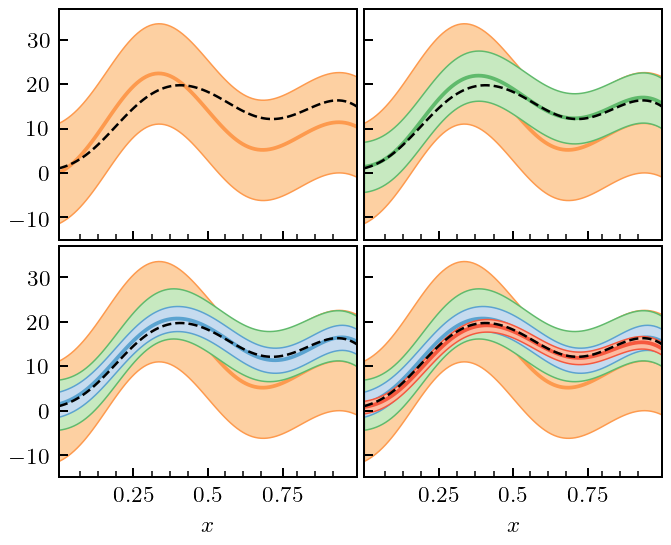

In [29]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(3.9, 3.2))
for i, n in enumerate(orders):
    _, std_trunc = gp_trunc.predict(X, order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x, data[:, i], zorder=i-5, c=colors[i])
        ax.fill_between(x, data[:, i] + 2*std_trunc, data[:, i] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(x, data_true, color=softblack, lw=1, ls='--')
    # ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xticks([0.25, 0.5, 0.75])
    ax.set_xticks(x[x_valid_mask], minor=True)
    ax.set_xticklabels([0.25, 0.5, 0.75])
    ax.set_yticks([0, 10, 20])
    ax.set_yticks([-10, 0, 10, 20, 30])
    ax.set_ylim(-15, 37)
# Format
axes[1, 0].set_xlabel(r'$x$')
axes[1, 1].set_xlabel(r'$x$')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
fig.savefig('figures/toy_truncation_error_bands')

In [30]:
norm_trunc_cov = gp_trunc.cov(X[x_valid_mask], start=0, end=0)
norm_residuals = (data_true[x_valid_mask, None] - data[x_valid_mask]) / (ratio**(orders+1) / np.sqrt(1 - ratio**2))
gr_dgn_trunc = gm.GraphicalDiagnostic(norm_residuals, mean=np.zeros(x[x_valid_mask].shape[0]), cov=norm_trunc_cov,
                                      colors=colors, gray=gray, black=softblack)

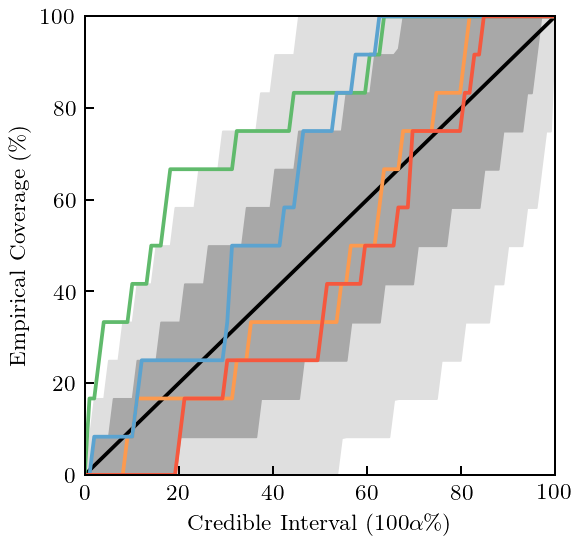

In [31]:
fig, ax = plt.subplots(figsize=(3.4, 3.2))
gr_dgn_trunc.credible_interval(
    np.linspace(1e-5, 1, 100), band_perc=[0.68, 0.95], ax=ax, title=None,
    xlabel=r'Credible Interval ($100\alpha\%$)', ylabel=r'Empirical Coverage ($\%$)')
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
fig.tight_layout();
fig.savefig('figures/toy_truncation_error_credible_intervals')

### Figure 9: The $Q$ and $\ell$ Posterior

Here we generate the 2D posterior for the EFT expansion parameter $Q$ and the GP lengthscale $\ell$.
We also show the 1D marginal distributions for $Q$ and $\ell$. And all in one plot!

In [32]:
# Define the grid on which we want to plot the results
ls_vals = np.linspace(1e-3, 0.5, 100)
ratio_vals = np.linspace(0.3, 0.7, 80)

In [33]:
# Compute the log likelihood for values on this grid. 
ls_ratio_loglike = np.array([[
    gp_trunc.log_marginal_likelihood(theta=[ls_,], ratio=ratio_val) for ls_ in np.log(ls_vals)]
    for ratio_val in ratio_vals
])

In [34]:
# Makes sure that the values don't get too big or too small
ls_ratio_like = np.exp(ls_ratio_loglike - np.max(ls_ratio_loglike))

# Now compute the marginal distributions
ratio_like = np.trapz(ls_ratio_like, x=ls_vals, axis=-1)
ls_like = np.trapz(ls_ratio_like, x=ratio_vals, axis=0)

# Normalize them
ratio_like /= np.trapz(ratio_like, x=ratio_vals, axis=0)
ls_like /= np.trapz(ls_like, x=ls_vals, axis=0)

In [35]:
def joint_plot(ratio=1, height=3):
    """Taken from Seaborn JointGrid"""
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)
    
    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig, ax_joint, ax_marg_x, ax_marg_y

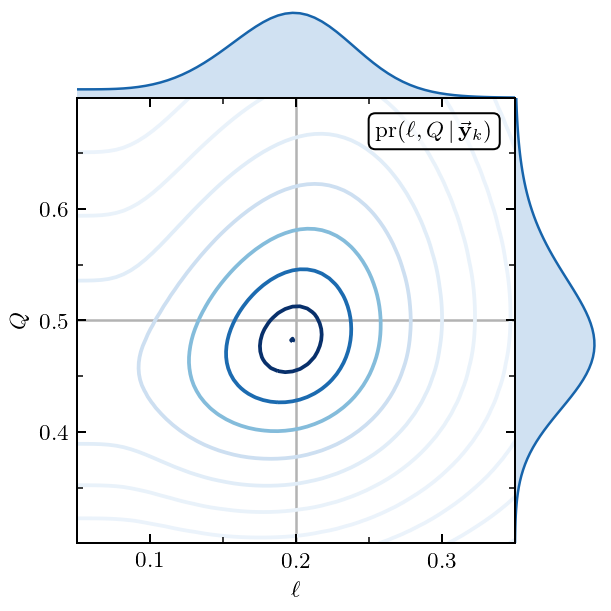

In [36]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    cmap_name = 'Blues'
    cmap = mpl.cm.get_cmap(cmap_name)

    # Setup axes
    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

    # Plot contour
    ax_joint.contour(ls_vals, ratio_vals, ls_ratio_like,
                     levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                     cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

    # Now plot the marginal distributions
    ax_marg_y.plot(ratio_like, ratio_vals, c=cmap(0.8), lw=1)
    ax_marg_y.fill_betweenx(ratio_vals, np.zeros_like(ratio_like),
                            ratio_like, facecolor=cmap(0.2), lw=1)
    ax_marg_x.plot(ls_vals, ls_like, c=cmap(0.8), lw=1)
    ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                           ls_like, facecolor=cmap(0.2), lw=1)

    # Formatting
    ax_joint.set_xlabel(r'$\ell$')
    ax_joint.set_ylabel(r'$Q$')
    ax_joint.axvline(ls, 0, 1, c=gray, lw=1, zorder=0)
    ax_joint.axhline(ratio, 0, 1, c=gray, lw=1, zorder=0)
    ax_joint.margins(x=0, y=0.)
    ax_joint.set_xlim(0.05, 0.35)
    ax_joint.set_xticks([0.1, 0.2, 0.3])
    ax_joint.set_xticks([0.15, 0.25], minor=True)
    ax_joint.set_yticks([0.4, 0.5, 0.6])
    ax_joint.set_yticks([0.35, 0.45, 0.55, 0.65], minor=True)
    ax_marg_x.set_ylim(bottom=0);
    ax_marg_y.set_xlim(left=0);
    ax_joint.text(0.95, 0.95, r'pr$(\ell, Q \,|\, \vec{\mathbf{y}}_k)$', ha='right', va='top',
                  transform=ax_joint.transAxes,
                  bbox=text_bbox
                 );

    plt.show()
    fig.savefig('figures/Q_ell_jointplot')

The best values for $Q$ and $\ell$ from their *joint* posterior are given by

In [37]:
ratio_map_idx, ls_map_idx = np.unravel_index(np.argmax(ls_ratio_like), ls_ratio_like.shape)
print('Best Q:', ratio_vals[ratio_map_idx])
print('Best length scale:', ls_vals[ls_map_idx])

Best Q: 0.4822784810126582
Best length scale: 0.19757575757575757


### Figure 10: Misestimated $Q$

Now we turn our attention to what failure looks like. In this particular case we deliberately misestimate the expansion parameter. This should cause the coefficients to systematically grow with order (if $Q$ is too small) or decrease with order (if $Q$ is too big). In either case the GPs representing coefficients at different orders will not have a common variance. We hope to be able to see that in our diagnostics.

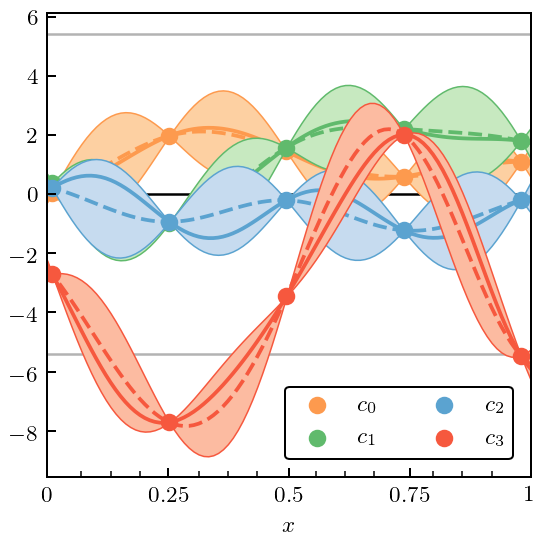

In [38]:
# Here we extract c_n from predictions y_n assuming Q=0.3, instead of the true Q=0.5
coeffs_wrong = gm.coefficients(data, ratio=0.3, ref=ref, orders=orders)

# Fit the GP to those coefficients
gp_diagnostic_wrong = gm.ConjugateGaussianProcess(kernel=kernel_fit, center=center0, disp=disp0, df=df0, scale=scale0)
gp_diagnostic_wrong.fit(X[x_train_mask], coeffs_wrong[x_train_mask])
pred, std = gp_diagnostic_wrong.predict(X, return_std=True)
underlying_std = np.sqrt(gp_diagnostic_wrong.cov_factor_)

# Now plot the results
fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(orders):
    ax.plot(x, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(x, coeffs_wrong[:, i], c=colors[i], zorder=i-5)
    ax.plot(x[x_train_mask], coeffs_wrong[x_train_mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
            label=r'$c_{}$'.format(n))
    ax.fill_between(x, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(x[x_valid_mask], minor=True)
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xlabel(r'$x$')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax.legend(ncol=2)
fig.tight_layout();
fig.savefig('figures/toy_interp_and_underlying_processes_small_Q')

Note that the fit to the coefficients does not look too bad by eye, although one might complain about the 95% DoB intervals covering the actual value too much of the time. 

We now print out the kernel and compute the mean and covariance matrix. 

In [39]:
gp_diagnostic_wrong.kernel_

RBF(length_scale=0.175) + WhiteKernel(noise_level=1e-10)

In [40]:
mean_wrong = gp_diagnostic_wrong.mean(X[x_valid_mask])
cov_wrong = gp_diagnostic_wrong.cov(X[x_valid_mask])
pred_wrong = gp_diagnostic_wrong.predict(X[x_valid_mask])
gr_dgn_wrong = gm.GraphicalDiagnostic(pred_wrong, mean=mean_wrong, cov=cov_wrong, colors=colors, gray=gray, black=softblack)

The last line here generates all the desired graphical diagnostics for this GP analysis (which should not look good).
Now we specifically print out the Mahalanobis distance squared of each GP and the PC errors.

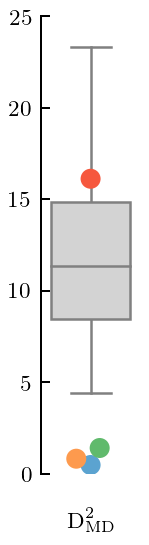

In [41]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_wrong.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 25)
ax.set_yticks([0, 5, 10, 15, 20, 25])
fig.tight_layout();
fig.savefig('figures/toy_md_small_Q')

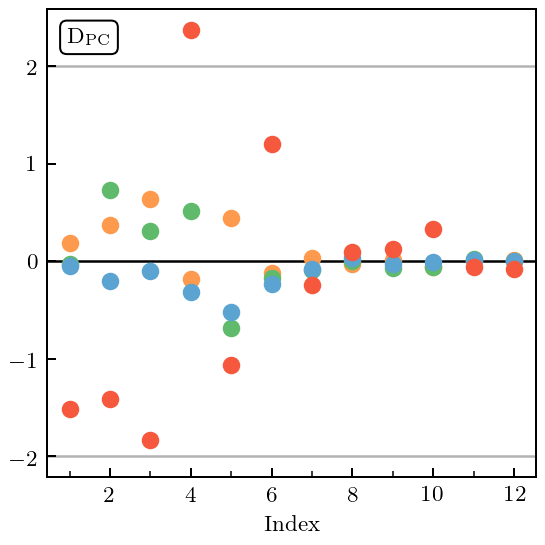

In [42]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_wrong.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xticks([1, 3, 5, 7, 9, 11], minor=True)
    ax.text(0.04, 0.96, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig('figures/toy_pc_vs_index_small_Q')

The $c_4$ coefficient is too large and has biased the estimation of $\bar c$ upwards. Thus, the MD is too small for most of the curves.
By looking at the PC decomposition, we see that there is a problem with the length scale estimation because the values become small at large index. Indeed, by inspecting the kernel, we see that the estimate of $\ell$ is too small (0.175, when the true value is 0.2).

## NN Scattering in Chiral EFT

In the last section of the paper we turn our attention to NN scattering in Chiral EFT. We apply the above ideas to the differential cross section vs angle at $E_{\rm lab}=150$ MeV, to the total cross section vs energy, and to the spin observable $A$ at 96 MeV.

In [43]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Return p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(E, Lambda_b, interaction='np', single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    # Interpolate to smooth the transition from m_pi to p
    n = 8
    p = E_to_p(E, interaction)
    q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
    return q

In [44]:
# We get the NN data from a separate place in our github respository.
nn_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-0p9fm.h5?raw=true'

response = urllib.request.urlopen(nn_url) 
h5file = tables.open_file("nn_observables_eft.h5", driver="H5FD_CORE",
                          driver_core_image=response.read(),
                          driver_core_backing_store=0)
SGT = h5file.get_node('/SGT').read()
DSG = h5file.get_node('/DSG').read()
AY = h5file.get_node('/PB').read()
A = h5file.get_node('/A').read()
D = h5file.get_node('/D').read()
AXX = h5file.get_node('/AXX').read()
AYY = h5file.get_node('/AYY').read()
q_cm = h5file.get_node('/q_cm').read()
t_lab = h5file.get_node('/t_lab').read()
degrees = h5file.get_node('/degrees').read()

q_cm *= hbarc

nn_online_pot = 'pwa93'
nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
nno_response = urllib.request.urlopen(nn_online_url) 
nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
                          driver_core_image=nno_response.read(),
                          driver_core_backing_store=0)
SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()
DSG_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/DSG').read()[:, :-1]
AY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/PB').read()[:, :-1]
A_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/A').read()[:, :-1]
D_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/D').read()[:, :-1]
AXX_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AXX').read()[:, :-1]
AYY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AYY').read()[:, :-1]

In [45]:
nn_orders = np.array([0, 2, 3, 4, 5])
# This ensures we only analyze the non-trivial information at
# O(Q^2), O(Q^3), O(Q^4), and O(Q^5)
excluded = [0]
nn_orders_mask = ~ np.isin(nn_orders, excluded)
Deg = degrees[:, None]
Lambdab = 600

### Figure 11: Differential Cross Section


In [46]:
# Define the kinematics of the dcs we are analyzing
t_lab_dsg = 150
t_lab_idx_dsg = np.nonzero(t_lab_dsg == t_lab)[0][0]
q_cm_dsg = q_cm[t_lab_idx_dsg]

deg_train_mask_dsg, deg_valid_mask_dsg = regular_train_test_split(degrees, dx_train=30, dx_test=10)
ratio_dsg = Q_approx(t_lab_dsg, Lambda_b=Lambdab)

dsg_train = DSG.T[deg_train_mask_dsg, t_lab_idx_dsg]
dsg_valid = DSG.T[deg_valid_mask_dsg, t_lab_idx_dsg]
dsg_vs_theta = DSG.T[:, t_lab_idx_dsg]
dsg_ref = dsg_vs_theta[:, -1]

# Compute the coefficients and define the kernel
coeffs_dsg = gm.coefficients(dsg_vs_theta, ratio=ratio_dsg, ref=dsg_ref, orders=nn_orders)[:, nn_orders_mask]
kernel_dsg = RBF(length_scale=40, length_scale_bounds=(20, 60)) + WhiteKernel(1e-10, noise_level_bounds='fixed')

gp_dsg = gm.ConjugateGaussianProcess(
    kernel_dsg, center=center0, disp=disp0, df=df0,
    scale=1, n_restarts_optimizer=10)

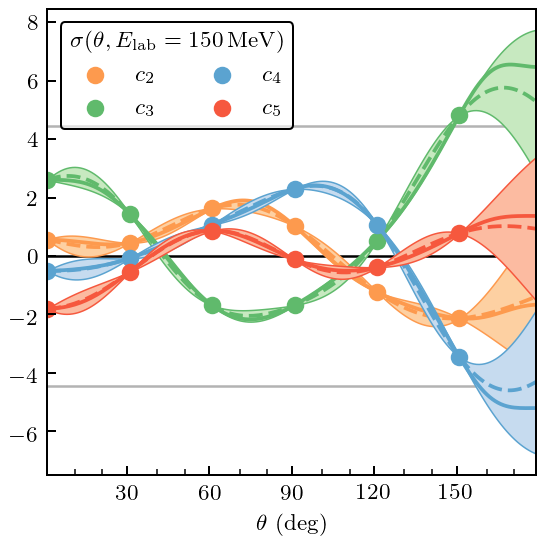

In [47]:
gp_dsg.fit(Deg[deg_train_mask_dsg], coeffs_dsg[deg_train_mask_dsg])
pred, std = gp_dsg.predict(Deg, return_std=True)
underlying_std = np.sqrt(gp_dsg.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(degrees, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(degrees, coeffs_dsg[:, i], c=colors[i], zorder=i-5)
    ax.plot(degrees[deg_train_mask_dsg], coeffs_dsg[deg_train_mask_dsg, i], c=colors[i], zorder=i-5,
            ls='', marker='o', label=r'$c_{}$'.format(n))
    ax.fill_between(degrees, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(degrees[deg_valid_mask_dsg], minor=True)
ax.set_xticks([30, 60, 90, 120, 150])
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xlabel(r'$\theta$ (deg)')
ax.legend(ncol=2, borderpad=0.4,# labelspacing=0.5, columnspacing=1.3,
          borderaxespad=0.6,
          title=r'$\sigma(\theta, E_{\mathrm{lab}}=150\,\mathrm{MeV})$')
fig.tight_layout();
fig.savefig('figures/dsg_interp_and_underlying_processes')

And then things follow as before: print out the kernel, define the mean and covariance, do the diagnostics, and plot Mahalanobis distance and Pivoted Cholesky errors.

In [48]:
gp_dsg.kernel_

RBF(length_scale=34) + WhiteKernel(noise_level=1e-10)

In [49]:
mean_dsg = gp_dsg.mean(Deg[deg_valid_mask_dsg])
cov_dsg = gp_dsg.cov(Deg[deg_valid_mask_dsg])
gr_dgn_dsg = gm.GraphicalDiagnostic(coeffs_dsg[deg_valid_mask_dsg], mean_dsg, cov_dsg, colors=colors,
                                    gray=gray, black=softblack)

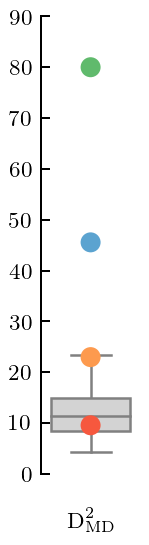

In [50]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_dsg.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 90)
fig.tight_layout();
fig.savefig('figures/dsg_md')

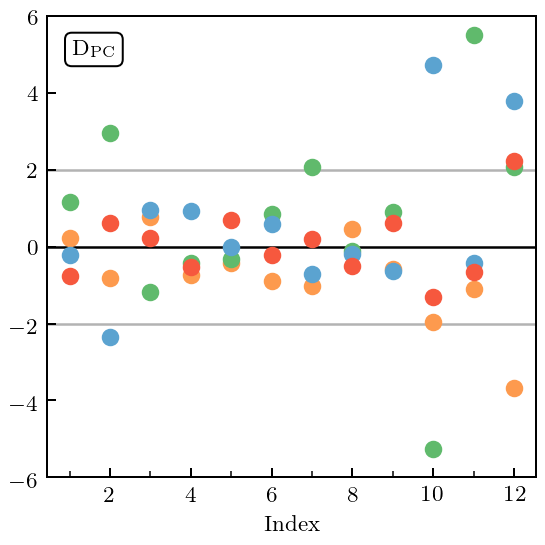

In [51]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_dsg.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xticks([1, 3, 5, 7, 9, 11], minor=True)
    ax.text(0.05, 0.95, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    ax.set_ylim(-6, 6)
    fig.tight_layout();
    plt.show()
    fig.savefig('figures/dsg_pc_vs_index')

In this case the $\mathcal{O}(Q^4)$ and $\mathcal{O}(Q^5)$ coefficients both have MDs that are too large. But now this can be traced to PC errors at too large an index, which is typically an indication of an incorrect correlation structure in the Gaussian Process. 

### Figure 12: Total Cross Section

In [52]:
# Split into training and testing data
tlab_train_mask_sgt, tlab_valid_mask_sgt = regular_train_test_split(t_lab, dx_train=100, dx_test=25, xmin=100)

# Define Q at each t_lab
ratio_sgt = Q_approx(t_lab, Lambda_b=Lambdab)

Tlab = t_lab[:, None]

sgt_train = SGT.T[tlab_train_mask_sgt]
sgt_valid = SGT.T[tlab_valid_mask_sgt]
sgt_ref = SGT[0]

# Extract the coefficients and define kernel
coeffs_sgt = gm.coefficients(SGT.T, ratio=ratio_sgt, ref=sgt_ref, orders=nn_orders)[:, nn_orders_mask]
kernel_sgt = RBF(length_scale=100, length_scale_bounds=(60, 150)) + WhiteKernel(1e-10, noise_level_bounds='fixed')

# Define the GP
gp_sgt = gm.ConjugateGaussianProcess(
    kernel_sgt, center=center0, disp=disp0, df=df0,
    scale=1, n_restarts_optimizer=10)

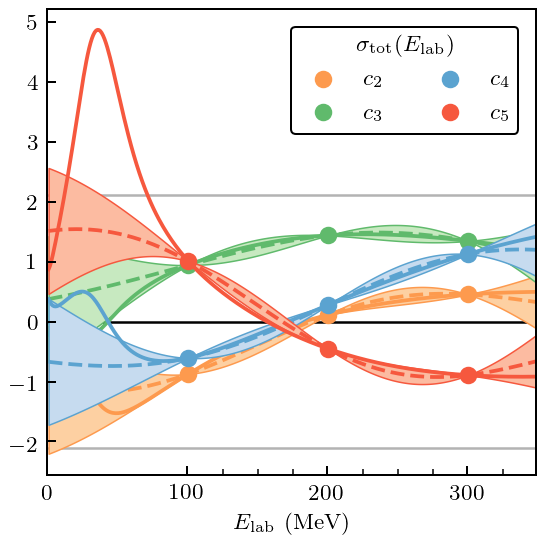

In [53]:
gp_sgt.fit(Tlab[tlab_train_mask_sgt], coeffs_sgt[tlab_train_mask_sgt])
pred, std = gp_sgt.predict(Tlab, return_std=True)
underlying_std = np.sqrt(gp_sgt.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(t_lab, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(t_lab, coeffs_sgt[:, i], c=colors[i], zorder=i-5)
    ax.plot(t_lab[tlab_train_mask_sgt], coeffs_sgt[tlab_train_mask_sgt, i], c=colors[i], zorder=i-5,
            ls='', marker='o', label=r'$c_{}$'.format(n))
    ax.fill_between(t_lab, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(t_lab[tlab_valid_mask_sgt], minor=True)
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xticks([0, 100, 200, 300])
ax.set_xlabel(r'$E_{\mathrm{lab}}$ (MeV)')
ax.legend(ncol=2, title=r'$\sigma_{\mathrm{tot}}(E_{\mathrm{lab}})$')
fig.tight_layout();
fig.savefig('figures/sgt_interp_and_underlying_processes_large_tlab')

Already from the plot it is clear that $c_5$ is problematic, although that problem occurs only at low energy. This will show up as a large MD and, once again, PC errors at high index that are too large.

In [54]:
gp_sgt.kernel_

RBF(length_scale=131) + WhiteKernel(noise_level=1e-10)

In [55]:
mean_sgt = gp_sgt.mean(Tlab[tlab_valid_mask_sgt])
cov_sgt = gp_sgt.cov(Tlab[tlab_valid_mask_sgt])
gr_dgn_sgt = gm.GraphicalDiagnostic(coeffs_sgt[tlab_valid_mask_sgt], mean_sgt, cov_sgt, colors=colors, gray=gray,
                                   black=softblack)

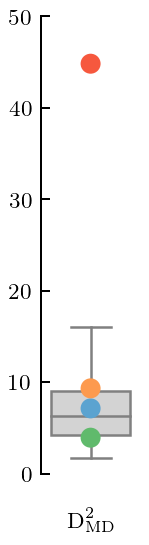

In [56]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_sgt.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 50)
fig.tight_layout();
fig.savefig('figures/sgt_md_large_tlab')

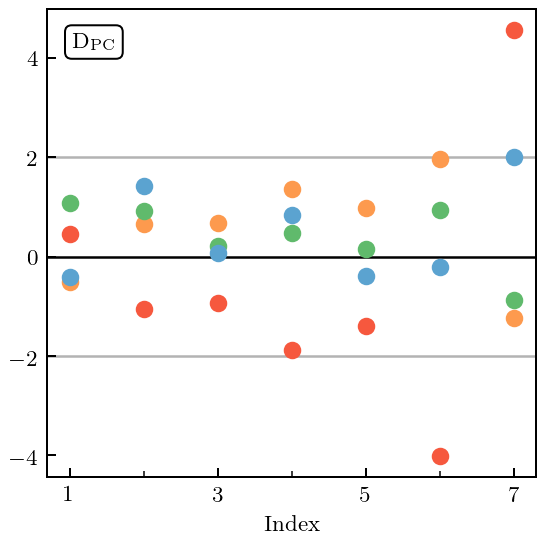

In [57]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_sgt.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6], minor=True)
    ax.set_xticks([1, 3, 5, 7])
    ax.text(0.05, 0.95, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig('figures/sgt_pc_vs_index_large_tlab')

### Figure 13: Spin Observable $A$

Finally, we look at an observable that has a symmetry constraint. The spin observable $A$, for which we choose the energy $T_{\rm lab}=96$ MeV. $A(\theta=0)=0$ (in the absence of magnetic-moment interactions). 

In [58]:
t_lab_A = 96
t_lab_idx_A = np.nonzero(t_lab_A == t_lab)[0][0]
q_cm_A = q_cm[t_lab_idx_A]

degrees_train_mask_A, degrees_valid_mask_A = regular_train_test_split(degrees, dx_train=40, dx_test=10)

ratio_A = Q_approx(t_lab_A, Lambda_b=Lambdab)

A_train = A.T[degrees_train_mask_A, t_lab_idx_A]
A_valid = A.T[degrees_valid_mask_A, t_lab_idx_A]
A_vs_theta = A.T[:, t_lab_idx_A]

coeffs_A = gm.coefficients(A_vs_theta, ratio=ratio_A, orders=nn_orders)

kernel_A = RBF(length_scale=30) + WhiteKernel(nugget, noise_level_bounds='fixed')

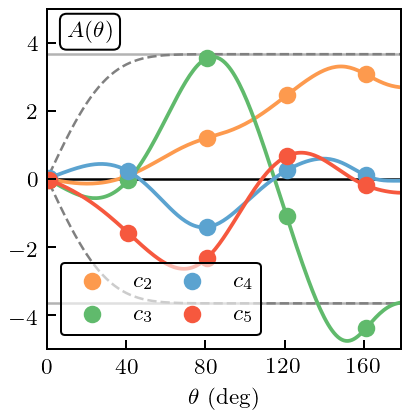

In [59]:
gp_coeffs_A = gm.ConjugateGaussianProcess(kernel=kernel_A, center=center0, disp=disp0, df=df0, scale=scale0)
gp_coeffs_A.fit(Deg[degrees_train_mask_A], coeffs_A[degrees_train_mask_A, 1:])

pred, std = gp_coeffs_A.predict(Deg, return_std=True)
underlying_std = np.sqrt(gp_coeffs_A.cov_factor_)

# Compute the std-dev under the symmetry constraint
dX_A = np.array([[0]])
std_interp = np.sqrt(np.diag(
    gp_coeffs_A.cov(Deg) -
    gp_coeffs_A.cov(Deg, dX_A) @ np.linalg.solve(gp_coeffs_A.cov(dX_A, dX_A), gp_coeffs_A.cov(dX_A, Deg))
))

fig, ax = plt.subplots(figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(degrees, coeffs_A[:, i+1], c=colors[i], zorder=i-5)
    ax.plot(degrees[degrees_train_mask_A], coeffs_A[degrees_train_mask_A, i+1], c=colors[i],
            zorder=i-5, ls='', marker='o', label=r'$c_{n}$'.format(n=n))


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.plot(degrees, 2*std_interp, color='gray', ls='--', zorder=-10, lw=1)
ax.plot(degrees, -2*std_interp, color='gray', ls='--', zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.tick_params(which='minor', bottom=False, top=True)
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_xticks([0, 40, 80, 120, 160])
ax.set_ylim(-5, 5)
leg = ax.legend(ncol=2, borderpad=0.4, columnspacing=0.8, borderaxespad=0.6)
# leg.legendPatch.set_facecolor('none')
ax.text(0.055, 0.965, r'$A(\theta)$', transform=ax.transAxes, va='top',
        bbox=dict(boxstyle="round", ec=softblack, fc='white', lw=0.8))
fig.tight_layout();
fig.savefig('figures/spin_obs_A_coefficients')

First we proceed as if we did not know that there was a symmetry at $\theta=0$.

In [60]:
gp_A = gm.TruncationGP(kernel_A, ref=1, ratio=ratio_A, center=center0, disp=disp0, df=df0, scale=scale0, excluded=excluded)

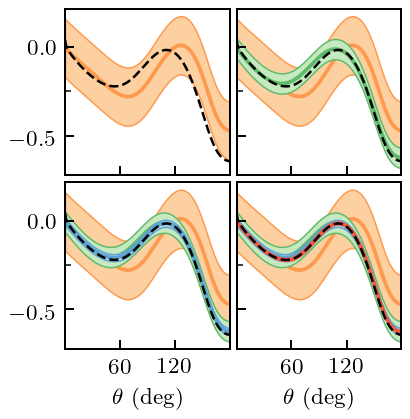

In [61]:
gp_A.fit(degrees[degrees_train_mask_A][:, None], A_train, orders=nn_orders)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    _, std_trunc = gp_A.predict(degrees[:, None], order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(degrees, A_vs_theta[:, i+1], zorder=i-5, c=colors[i])
        ax.fill_between(degrees, A_vs_theta[:, i+1] + 2*std_trunc, A_vs_theta[:, i+1] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(degrees, A_nn_online[t_lab_idx_A], color=softblack, lw=1, ls='--')
    ax.set_xticks([60, 120])
    ax.set_yticks([-0.5, 0])
    ax.set_yticks([-0.25,], minor=True)

# Format
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
fig.savefig('figures/spin_obs_A_full_pred_unconstrained')

And now we incorporate the constraint. We do not plot the revised coefficients, but only show the resulting EFT predictions, with truncation errors. The truncation errors now respect the symmetry constraint, because the GP does. 

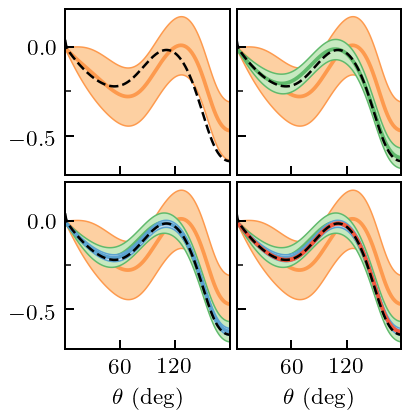

In [62]:
gp_A.fit(degrees[degrees_train_mask_A][:, None], A_train, orders=nn_orders, dX=np.array([[0]]), dy=[0])

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    _, std_trunc = gp_A.predict(degrees[:, None], order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(degrees, A_vs_theta[:, i+1], zorder=i-5, c=colors[i])
        ax.fill_between(degrees, A_vs_theta[:, i+1] + 2*std_trunc, A_vs_theta[:, i+1] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(degrees, A_nn_online[t_lab_idx_A], color=softblack, lw=1, ls='--')
    ax.set_xticks([60, 120])
    ax.set_yticks([-0.5, 0])
    ax.set_yticks([-0.25,], minor=True)

# Format
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
fig.savefig('figures/spin_obs_A_full_pred_constrained')